# Tracking through elements with autodiff

In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
from pytao import Tao
import matplotlib.pyplot as plt
import numdifftools as nd
from bmadx.track import *
tkwargs = {
    "dtype" : torch.double
}
import time
np.set_printoptions(precision= 15, suppress=False)
torch.set_printoptions(precision= 15, sci_mode=True)
torch.__version__, np.__version__

('1.11.0', '1.22.4')

In [2]:
from pathlib import Path

def find_repo(path):
    "Find repository root from the path's parents"
    for path in Path(path).parents:
        # Check whether "path/.git" exists and is a directory
        git_dir = path / ".git"
        if git_dir.is_dir():
            return path

import os
nb_dir = os.getcwd()
# Find the repo root where the script is
repo_path = str(find_repo(nb_dir))
repo_path

'/home/jg2347/Repositories/Bmad-X'

# Constants

In [3]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

# Drift tests

In [4]:
# Create drift
L=1.0 # Drift length in m
d1 = Drift(L=torch.tensor(L, **tkwargs)) #named tuple is in track.py module
d1

Drift(L=tensor(1.000000000000000e+00, dtype=torch.float64))

## Drift one particle test

In [5]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1,ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.109989500000000e+05, dtype=torch.float64))

In [6]:
#create track_a_drift_torch
track_a_drift_torch = make_track_a_drift(torch)
# Outgoing particle
p_out = track_a_drift_torch(p_in, d1)
x_py = torch.hstack([p_out.x,p_out.px,p_out.y,p_out.py,p_out.z,p_out.pz]).detach()
x_py

tensor([5.006027114522933e-03, 3.000000000000000e-03, -4.002009038174311e-03,
        -1.000000000000000e-03, 1.994652573892362e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [7]:
# bmad lattice for comparison
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_drift.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out=tao.orbit_at_s(ele=1)
#orbit_out

In [8]:
# bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([5.006027114522930e-03, 3.000000000000000e-03, -4.002009038174310e-03,
        -1.000000000000000e-03, 1.994652573892360e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [9]:
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Drift Jacobian test

In [10]:
f_drift = lambda x: track_a_drift_torch(Particle(*x, ts, tp0c, tmc2), d1)[:6]
J = jacobian(f_drift, tvec1)

In [11]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[ 1.000000000000000e+00,  1.002018092527393e+00,  0.000000000000000e+00,
         -3.018117694005117e-06,  0.000000000000000e+00, -3.012081458617107e-03],
        [ 0.000000000000000e+00,  1.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [ 0.000000000000000e+00, -3.018117694005117e-06,  1.000000000000000e+00,
          1.002010044213542e+00,  0.000000000000000e+00,  1.004027152872369e-03],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          1.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [ 0.000000000000000e+00, -3.012081458617106e-03,  0.000000000000000e+00,
          1.004027152872369e-03,  1.000000000000000e+00,  1.742165247481025e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [12]:
# Tao Jacobian
drift_tao = tao.matrix(0,1)
mat_tao = torch.tensor(drift_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.000000000000000e+00,  1.002018092527390e+00,  0.000000000000000e+00,
         -3.018117694005120e-06,  0.000000000000000e+00, -3.012081458617110e-03],
        [ 0.000000000000000e+00,  1.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [ 0.000000000000000e+00, -3.018117694005120e-06,  1.000000000000000e+00,
          1.002010044213540e+00,  0.000000000000000e+00,  1.004027152872370e-03],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          1.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00],
        [ 0.000000000000000e+00, -3.012081458617110e-03,  0.000000000000000e+00,
          1.004027152872370e-03,  1.000000000000000e+00,  1.742165247481030e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [13]:
# is it close to Tao result?
torch.allclose(mat_py, mat_tao, atol=0, rtol=1.0e-14)

True

# Quadrupole tests

In [14]:
def torch_quadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                     X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                     Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                     TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                      Y_OFFSET=Y_OFFSET, TILT=TILT)

In [15]:
# Create quad
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x
#NUM_STEPS = 1 #number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
q1

Quadrupole(L=tensor(1.000000000000000e-01, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64))

## Quadrupole one particle test

In [16]:
# create track_a_quadrupole_torch
track_a_quadrupole_torch = make_track_a_quadrupole(torch)
# Outgoing particle
p_out = track_a_quadrupole_torch(p_in, q1)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.196239719302552e-03, 8.841834264853368e-04, -3.253441973269224e-03,
        -4.100871741572859e-03, 1.999394664225331e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [17]:
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

In [18]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.196239719302550e-03, 8.841834264853370e-04, -3.253441973269220e-03,
        -4.100871741572860e-03, 1.999394664225330e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [19]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Quadrupole Jacobian test

In [20]:
f_quadrupole = lambda x: track_a_quadrupole_torch(Particle(*x,ts, tp0c, tmc2), q1)[:6]
J = jacobian(f_quadrupole, tvec1)

In [21]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[ 9.503167431875498e-01,  9.853541097581728e-02,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00, -1.924858550317723e-04],
        [-9.833834015386563e-01,  9.503167431875498e-01, -0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.149663908944082e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  1.050519938506054e+00,
          1.018821577510623e-01,  0.000000000000000e+00,  2.569093937337833e-04],
        [-0.000000000000000e+00,  0.000000000000000e+00,  1.016783934355602e+00,
          1.050519938506054e+00,  0.000000000000000e+00,  1.017485822657404e-04],
        [ 8.003290869842023e-05, -1.942507914386516e-04,  1.543324297486644e-04,
          2.595220753974964e-04,  1.000000000000000e+00,  1.756709202142694e-05],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [22]:
# Bmad Jacobian
quad_tao = tao.matrix(0,1)
mat_tao = torch.tensor(quad_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 9.503167431875500e-01,  9.853541097581731e-02,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00, -1.924858550317720e-04],
        [-9.833834015386560e-01,  9.503167431875500e-01,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.149663908944080e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  1.050519938506050e+00,
          1.018821577510620e-01,  0.000000000000000e+00,  2.569093937337830e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  1.016783934355600e+00,
          1.050519938506050e+00,  0.000000000000000e+00,  1.017485822657410e-04],
        [ 8.003290869842020e-05, -1.942507914386520e-04,  1.543324297486640e-04,
          2.595220753974960e-04,  1.000000000000000e+00,  1.756709202142690e-05],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [23]:
# close to Tao result?
torch.allclose(mat_py, mat_tao, atol=0, rtol=1.0e-14)

True

## Quadrupole offset test

In [24]:
# Quad params
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x

# quad w/o offsets
q_no_off = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
# quad with offsets
x_off = 1e-3
y_off = -2e-3
q_off = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs), 
                         X_OFFSET=torch.tensor(x_off, **tkwargs),
                         Y_OFFSET=torch.tensor(y_off, **tkwargs) )

In [25]:
# Outgoing particle no offset
p_out = track_a_quadrupole_torch(p_in, q_no_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.196239719302552e-03, 8.841834264853368e-04, -3.253441973269224e-03,
        -4.100871741572859e-03, 1.999394664225331e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [26]:
# Outgoing particle offset
p_out = track_a_quadrupole_torch(p_in, q_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.245922976115002e-03, 1.867566828023993e-03, -3.152402096257116e-03,
        -2.067303872861656e-03, 1.999538606428305e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [27]:
%%time
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_quad_offset.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

CPU times: user 12.1 ms, sys: 925 µs, total: 13 ms
Wall time: 13.3 ms


In [28]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.245922976115000e-03, 1.867566828023990e-03, -3.152402096257120e-03,
        -2.067303872861660e-03, 1.999538606428300e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [29]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Quadrupole tilt test (transverse rotation)

In [30]:
# Quad params
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x

# quad w/o offsets
q_no_off = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs))
# quad with offsets
tilt = 0.3
q_off = torch_quadrupole(L=torch.tensor(L, **tkwargs), K1=torch.tensor(K1, **tkwargs),
                         TILT = torch.tensor(tilt, **tkwargs))

In [31]:
# Outgoing particle no offset
p_out = track_a_quadrupole_torch(p_in, q_no_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.196239719302552e-03, 8.841834264853368e-04, -3.253441973269224e-03,
        -4.100871741572859e-03, 1.999394664225331e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [32]:
# Outgoing particle offset
p_out = track_a_quadrupole_torch(Particle(*tvec1,ts, tp0c, tmc2), q_off)
x_py = torch.hstack(p_out[:6]).detach()
x_py

tensor([2.300431812756860e-03, 2.982152956166943e-03, -3.286310353406088e-03,
        -4.782331681936468e-03, 1.999046404985869e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [33]:
%%time
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_quad_tilt.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

CPU times: user 12.4 ms, sys: 477 µs, total: 12.9 ms
Wall time: 13.1 ms


In [34]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.300431812756860e-03, 2.982152956166940e-03, -3.286310353406090e-03,
        -4.782331681936470e-03, 1.999046404985870e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [35]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

# Lattice tracking

## Lattice one particle test

In [36]:
# Create drift
L_d = 1.0 # Drift length in m
d1 = Drift(torch.tensor(L_d, **tkwargs))
# Create quad
L_q = 0.1  # quad length in m
K1 = 10  # Quad focusing strength. Positive is focusing in x
#NUM_STEPS = 1  # number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = torch_quadrupole(L=torch.tensor(L_q, **tkwargs), K1=torch.tensor(K1, **tkwargs))

In [37]:
# Lattice example
lattice = [d1, q1, d1, q1, d1]  # lattice is a list of elements
# List of particle coordinates after each element:
x_list = [torch.hstack(coords[:6]).detach() for coords in track_a_lattice(p_in, lattice)]
# Outgoing particle after complete lattice:
x_py = torch.hstack(track_a_lattice(p_in, lattice)[-1][:6]).detach()
# alternative: x_list[-1]
x_py

tensor([-2.281967961209991e-03, -4.896330349656308e-03, -2.543913165908659e-02,
        -1.497282967847466e-02, 1.847324681974169e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [38]:
# Bmad lattice to compare
tao = Tao('-lat '+repo_path+'/tests/bmad_lattices/test_drift_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=5)

In [39]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([-2.281967961209990e-03, -4.896330349656310e-03, -2.543913165908660e-02,
        -1.497282967847470e-02, 1.847324681974170e-03, -2.000000000000000e-03],
       dtype=torch.float64)

In [40]:
# close to Tao result?
torch.allclose(x_py, x_tao, atol=0, rtol=1.0e-14)

True

## Lattice Jacobian test

In [41]:
f_driftquadrupole = lambda x: track_a_lattice(Particle(*x, ts, tp0c, tmc2), lattice)[-1][:6]
J = jacobian(f_driftquadrupole, tvec1)

In [42]:
# Jacobian matrix
mat_py = torch.vstack(J)
mat_py

tensor([[-1.032202390317458e+00, -7.256968115101181e-02,  2.336717479636538e-04,
          4.049003895819779e-04,  0.000000000000000e+00,  8.218283945153969e-03],
        [-9.000515317112638e-01, -1.032080978292848e+00, -1.067067115329933e-05,
         -1.900037293643618e-05,  0.000000000000000e+00,  5.547564231500580e-04],
        [-8.812732879846703e-05, -9.339294371369415e-05,  5.457258390307320e+00,
          9.071019578396722e+00,  0.000000000000000e+00,  3.361265895544615e-02],
        [-1.067067115329933e-05, -9.954618543668099e-06,  3.172268131080336e+00,
          5.456165751278677e+00,  0.000000000000000e+00,  9.391470418309955e-03],
        [-6.823789171283308e-03, -8.441133541388406e-03,  5.537646874208031e-02,
          9.820564579614072e-02,  1.000000000000000e+00,  9.919963196451456e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [43]:
# Bmad Jacobian
lat_tao = tao.matrix(0,5)
mat_tao = torch.tensor(lat_tao['mat6'], **tkwargs)
mat_tao

tensor([[-1.032202390317460e+00, -7.256968115101139e-02,  2.336717479636540e-04,
          4.049003895819780e-04,  0.000000000000000e+00,  8.218283945153960e-03],
        [-9.000515317112640e-01, -1.032080978292850e+00, -1.067067115329930e-05,
         -1.900037293643620e-05,  0.000000000000000e+00,  5.547564231500580e-04],
        [-8.812732879846700e-05, -9.339294371369409e-05,  5.457258390307320e+00,
          9.071019578396720e+00,  0.000000000000000e+00,  3.361265895544610e-02],
        [-1.067067115329930e-05, -9.954618543668099e-06,  3.172268131080340e+00,
          5.456165751278680e+00,  0.000000000000000e+00,  9.391470418309950e-03],
        [-6.823789171283310e-03, -8.441133541388410e-03,  5.537646874208030e-02,
          9.820564579614070e-02,  1.000000000000000e+00,  9.919963196451461e-04],
        [ 0.000000000000000e+00,  0.000000000000000e+00,  0.000000000000000e+00,
          0.000000000000000e+00,  0.000000000000000e+00,  1.000000000000000e+00]],
       dtype=torch.fl

In [44]:
# close to Tao result?
torch.allclose(mat_py, mat_tao, atol=0, rtol=1.0e-14)

True

## Multi-particle propagation through lattice

In [45]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
bunch_in = Particle(*sample.T, ts, tp0c, tmc2)

In [46]:
bunch_out = track_a_lattice(bunch_in, lattice)

In [47]:
# some beam properties up and downstream
torch.std(bunch_out[0].y),torch.std(bunch_out[-1].y)

(tensor(9.987231161940678e-04, dtype=torch.float64),
 tensor(1.456680534410338e-02, dtype=torch.float64))

## Stub element test

In [48]:
# divide a quad into 10 parts
divided_quad = stub_element(q1, 10)
divided_quad

[Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor(0., dtype=torch.float64)),
 Quadrupole(L=tensor(1.000000000000000e-02, dtype=torch.float64), K1=tensor(1.000000000000000e+01, dtype=torch.float64), NUM_STEPS=1, X_OFFSET=tensor(0., dtype=torch.float64), Y_OFFSET=tensor(0., dtype=torch.float64), TILT=tensor

## Plotting using stub_element

In [49]:
# make a quadrupole triplet
L_d = 1.5  # Drift length in m
d1 = Drift(torch.tensor(L_d, **tkwargs)) # drift
L_q = 0.1  # Quadrupole length in m
K1 = 10  # Quadrupole strengths
NUM_STEPS = 1
q1 = torch_quadrupole(L=torch.tensor(L_q,**tkwargs), K1=torch.tensor(K1, **tkwargs))  # x-focusing
q2 = torch_quadrupole(L=torch.tensor(L_q,**tkwargs), K1=torch.tensor(-K1, **tkwargs))  # y-focusing
lattice = [d1, q1, d1, q2, d1, q1, d1]

# stub each element into n equal parts each
n=50
stubbed_lattice = stub_lattice(lattice, n)

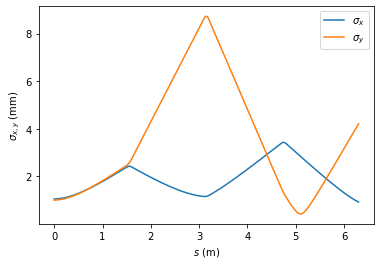

In [50]:
all_p = track_a_lattice(bunch_in, stubbed_lattice)
stdx = np.array([torch.std(par.x).item() for par in all_p])
stdy = np.array([torch.std(par.y).item() for par in all_p])
s = np.array([par.s.item() for par in all_p])
plt.plot(s, stdx*1000, label=r'$\sigma_x$')
plt.plot(s, stdy*1000, label=r'$\sigma_y$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

# Hessian Matrix example

In [51]:
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(torch.tensor(L_d, **tkwargs))

def sigmax_end(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(torch_quadrupole(L=torch.tensor(L_q, **tkwargs), K1=k1))
        lattice.append(drift)

    bunch_out = track_a_lattice(bunch_in, lattice)[-1]
    return torch.std(bunch_out.x)

#k1s = torch.tensor([10,-10,10,-10,10,-10,10,-10,10,-10], **tkwargs)
k1s = torch.zeros(10, **tkwargs)

In [52]:
#Hessian using autodiff
%time
hessian_py = hessian(sigmax_end,k1s)
hessian_py

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 19.6 µs


tensor([[6.354724798661209e-05, 1.992592869692199e-04, 3.161904436649551e-04,
         3.978970851406439e-04, 4.443792113962862e-04, 4.556368224318822e-04,
         4.316699182474319e-04, 3.724784988429353e-04, 2.780625642183921e-04,
         1.484221143738027e-04],
        [1.992592869692200e-04, 4.160507036374212e-05, 2.983195883724180e-04,
         5.121288195598074e-04, 6.531274029657195e-04, 7.213153385901539e-04,
         7.166926264331107e-04, 6.392592664945899e-04, 4.890152587745917e-04,
         2.659606032731159e-04],
        [3.161904436649551e-04, 2.983195883724179e-04, 2.591283133374886e-05,
         3.689991039483512e-04, 6.416871024687136e-04, 8.040042874793964e-04,
         8.559506589803996e-04, 7.975262169717230e-04, 6.287309614533669e-04,
         3.495648924253310e-04],
        [3.978970851406438e-04, 5.121288195598074e-04, 3.689991039483512e-04,
         1.515310660519437e-05, 4.100583099052690e-04, 7.037036690996101e-04,
         8.494440158892985e-04, 8.472793502

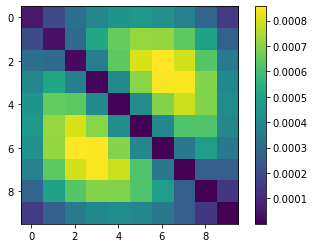

In [53]:
plt.imshow(hessian_py.detach().numpy())
plt.colorbar()
#plt.savefig("hessian.eps")

In [54]:
#Hessian using numerical differentiation

bunch_in_np = Particle(*sample.detach().numpy().T, 0, p0c, mc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L_d)
def sigmax_end2(k1s):
    """returns x beamsize after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    
    for k1 in k1s:
        lattice.append(Quadrupole(L=L_q, K1=k1))
        lattice.append(drift)

    bunch_out = track_a_lattice(bunch_in_np, lattice)[-1]
    
    return np.std(bunch_out.x)

#k1s = np.array([10,-10,10,-10,10,-10,10,-10,10,-10])
k1s = np.zeros(10)

In [55]:
%time
hessian_nd = nd.Hessian(sigmax_end2)(k1s)
hessian_nd

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 15.7 µs


array([[6.913713502232664e-05, 2.222357770433755e-04,
        3.441907867420647e-04, 4.292424654494358e-04,
        4.773908131763227e-04, 4.886358299088996e-04,
        4.629775156578635e-04, 4.004158704274112e-04,
        3.009508942093787e-04, 1.645825870067329e-04],
       [2.222357770433755e-04, 5.169062634783493e-05,
        3.330047833070372e-04, 5.500929714354419e-04,
        6.927104938104664e-04, 7.608573504014797e-04,
        7.545335412060309e-04, 6.737390662338129e-04,
        5.184739254900054e-04, 2.887381189724523e-04],
       [3.441907867420647e-04, 3.330047833070372e-04,
        3.935997937279484e-05, 4.120143452914304e-04,
        6.862554091354613e-04, 8.484844262414411e-04,
        8.987013966590806e-04, 8.369063203343174e-04,
        6.630991972884052e-04, 3.772800275163299e-04],
       [4.292424654494358e-04, 5.500929714354419e-04,
        4.120143452914304e-04, 3.082842872833294e-05,
        4.580255591665833e-04, 7.515170575059338e-04,
        8.954810820201329

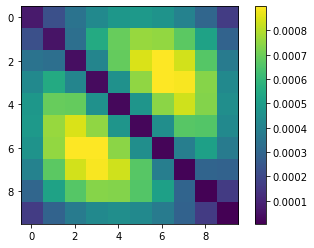

In [56]:
plt.imshow(hessian_nd)
plt.colorbar()

In [57]:
np.allclose(hessian_nd, hessian_py.detach().numpy())

False

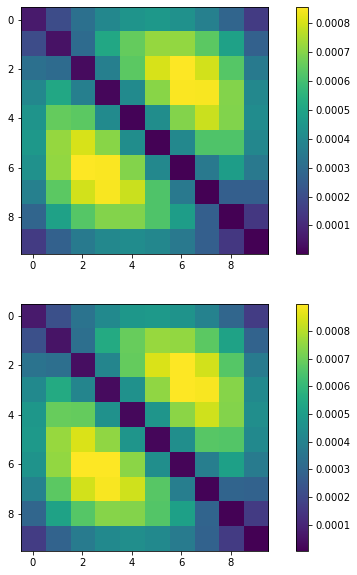

In [58]:
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hessian_py.detach().numpy())
fig.colorbar(cm,ax=axs[0])
#ax.imshow(hessian_py.detach().numpy())
#ax = axs[1]
#ax.imshow(1-hessian_nd)
cm = axs[1].imshow(hessian_nd)
fig.colorbar(cm,ax=axs[1])